# Distortion Classification

In [1]:
import torch
import torchaudio
import os

#### Add Tensorboard to record data

In [2]:
from torch.utils.tensorboard import SummaryWriter

EXPERIMENT_NAME = "c53_classify"
LOG_DIR = "_log/" + EXPERIMENT_NAME

if not os.path.exists('%s' % LOG_DIR):
    os.makedirs('%s' % LOG_DIR)

log_writer = SummaryWriter(LOG_DIR)


### Load dataset

Using device cpu
There are 585 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])
input feature:


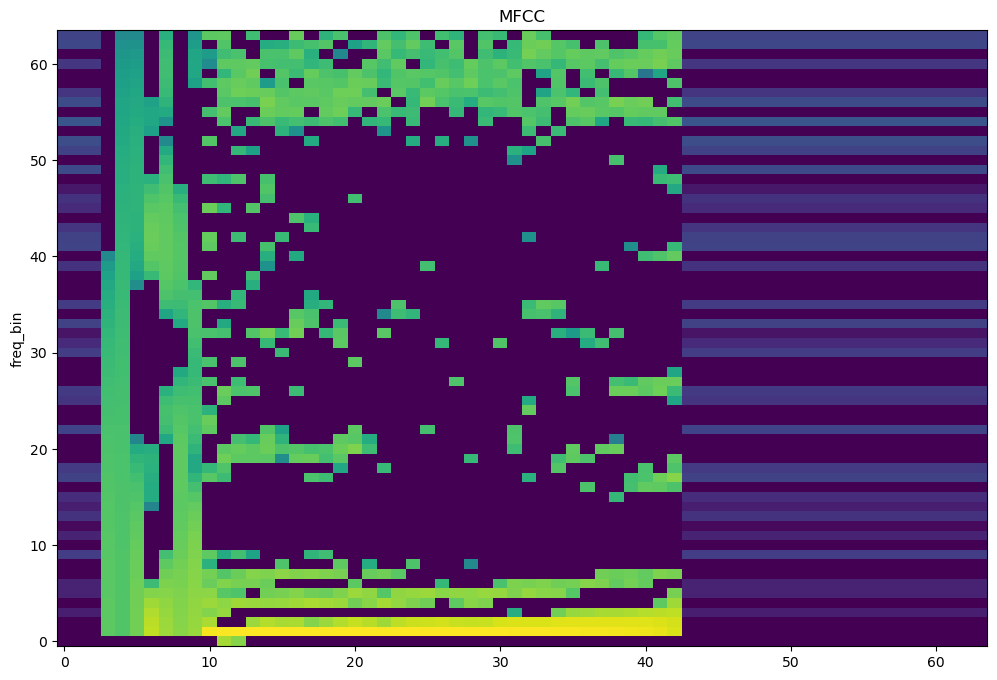

In [3]:
from src.gtfxdataset import GtFxDataset
from src.util import plot_spectrogram

AUDIO_DIR = "_assets/DATASET/GT-FX-SINGLE/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, filename = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")

print("input feature:")
log_writer.add_figure("Input Feature", plot_spectrogram(signal[0], title="MFCC"))

#### Split dataset into train and test sets

In [4]:
from src.classifier import train

BATCH_SIZE = round(len(fxData) / 200)

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)

#### Model training

In [5]:
from src.classifier import model
from torch import nn

LEARNING_RATE = 0.001
EPOCHS = 10

# construct model and assign it to device
cnn = model.Classifier().to(device)

log_writer.add_graph(cnn, signal.unsqueeze_(0))

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            log_writer,
            EPOCHS)


c:\Users\roger\miniconda3\envs\torchaudio\lib\site-packages\torch\jit\_trace.py:1056: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


Epoch 1
loss: 3.610608  [  0/469]
loss: 6.167247  [ 60/469]
loss: 3.773799  [120/469]
loss: 2.604903  [180/469]
loss: 3.047132  [240/469]
loss: 3.108031  [300/469]
loss: 2.572074  [360/469]
loss: 3.256299  [420/469]
distortion: Accuracy: 94.8%, avg loss: 0.166160
chorus: Accuracy: 51.7%, avg loss: 0.793635
tremolo: Accuracy: 39.7%, avg loss: 1.129564
delay: Accuracy: 82.8%, avg loss: 0.365625
reverb: Accuracy: 69.0%, avg loss: 0.594950
Total: avg loss: 3.049933
learning rate: 0.001000 -> 0.000910
---------------------------

Epoch 2
loss: 3.439040  [  0/469]
loss: 3.112773  [ 60/469]
loss: 2.022919  [120/469]
loss: 2.457518  [180/469]
loss: 1.652866  [240/469]
loss: 2.548884  [300/469]
loss: 1.118879  [360/469]
loss: 1.451509  [420/469]
distortion: Accuracy: 82.8%, avg loss: 0.335463
chorus: Accuracy: 58.6%, avg loss: 0.712144
tremolo: Accuracy: 60.3%, avg loss: 0.760720
delay: Accuracy: 84.5%, avg loss: 0.395024
reverb: Accuracy: 70.7%, avg loss: 0.663023
Total: avg loss: 2.866375
lea

#### Save model weight and bias

In [6]:
WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, EXPERIMENT_NAME + ".pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Trained feed forward net saved at _weights/c53_classify.pth


#### Evaluation

distortion: Accuracy: 100.0%, avg loss: 0.010522
chorus: Accuracy: 94.8%, avg loss: 0.128446
tremolo: Accuracy: 93.1%, avg loss: 0.144970
delay: Accuracy: 98.3%, avg loss: 0.043892
reverb: Accuracy: 94.8%, avg loss: 0.062502
Total: avg loss: 0.390332
[[15  0]
 [ 0 43]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        43

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



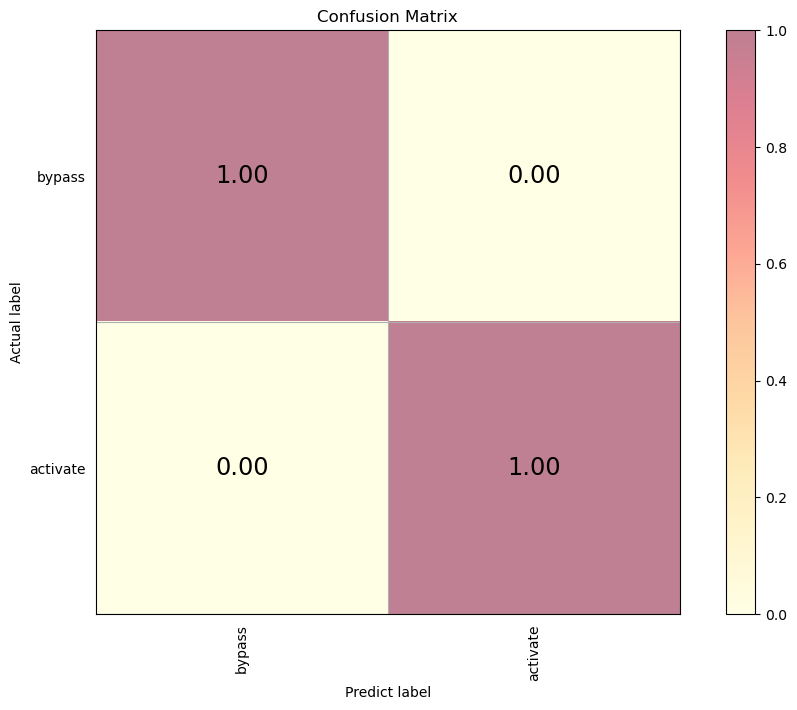

[[36  3]
 [ 0 19]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        39
           1       0.86      1.00      0.93        19

    accuracy                           0.95        58
   macro avg       0.93      0.96      0.94        58
weighted avg       0.96      0.95      0.95        58



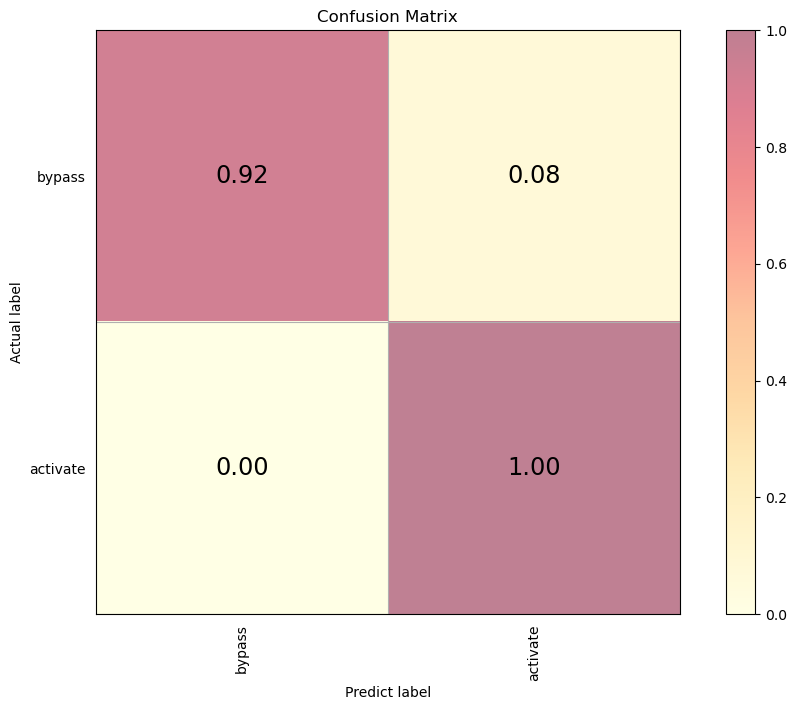

[[25  1]
 [ 3 29]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.93        26
           1       0.97      0.91      0.94        32

    accuracy                           0.93        58
   macro avg       0.93      0.93      0.93        58
weighted avg       0.93      0.93      0.93        58



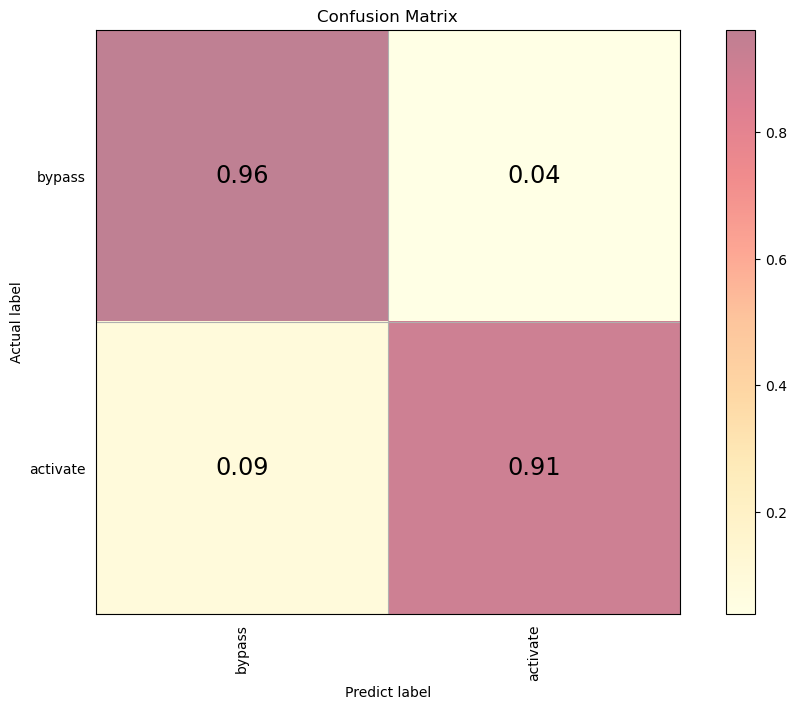

[[32  0]
 [ 1 25]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.96      0.98        26

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



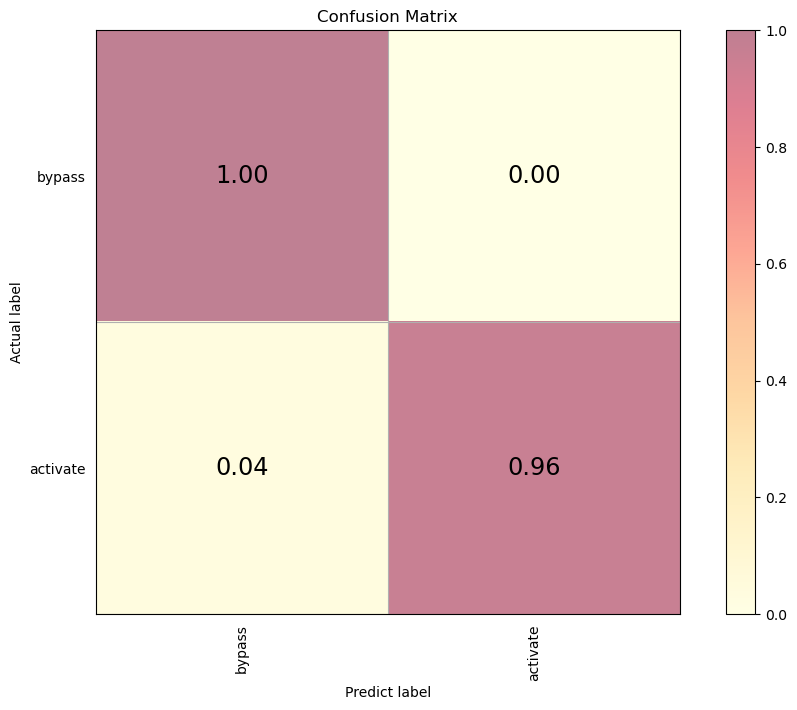

[[33  2]
 [ 1 22]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.92      0.96      0.94        23

    accuracy                           0.95        58
   macro avg       0.94      0.95      0.95        58
weighted avg       0.95      0.95      0.95        58



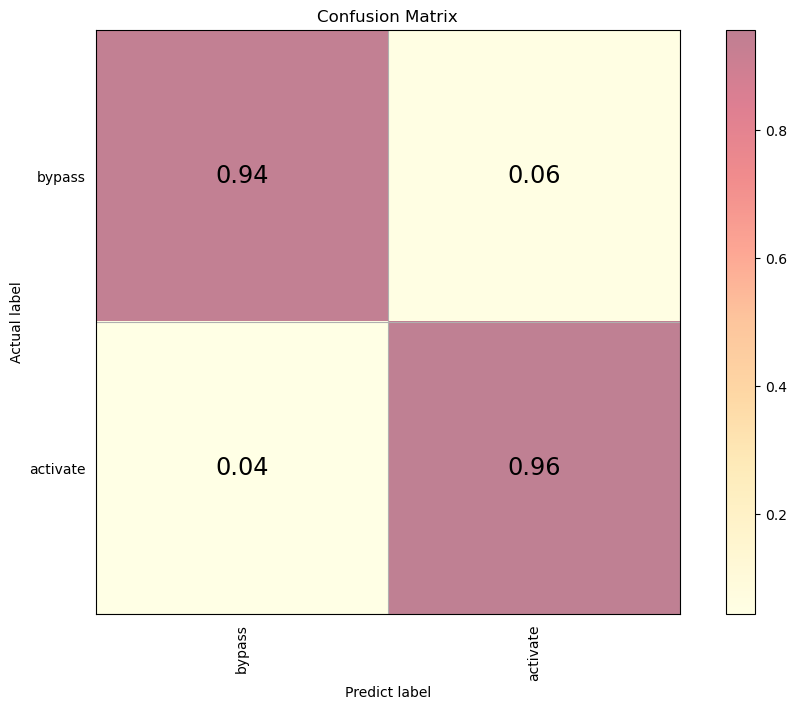

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']
EFFECT_MAP = ["distortion", "chorus", "tremolo", "delay", "reverb"]

cnn = model.Classifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

_, _, log = train.test(cnn, val_dataloader, device)

for i in range(5):
    expected = []
    predicted = []
    for index, data in enumerate(log[i]):
        predicted.append(data[1])
        expected.append(data[2])
    mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
    print(mat_con)
    print(classification_report(expected, predicted))
    
    log_writer.add_figure("Confusion Matrix/" + EFFECT_MAP[i],
                          plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID))

log_writer.close()